# [Контест](https://www.kaggle.com/competitions/games-rating/data) на Kaggle

Датасет хранит данные о настольных играх с веб-сайта BoardGameGeek (BGG) в феврале 2021 года. BGG — это крупнейшая онлайн-коллекция данных о настольных играх, которая состоит из данных о более чем 100 000 игр (с рейтингом и без рейтинга).

В данном соревновании необходимо реализовать линейную регрессию, которая сможет предсказывать средний рейтинг игры (`Rating Average`).

In [34]:
%pip install opendatasets
import opendatasets as od

In [35]:
od.download_kaggle_dataset("https://www.kaggle.com/competitions/games-rating/data", "")

Skipping, found downloaded files in "games-rating" (use force=True to force download)


## Данные: анализ и обработка

In [36]:
import pandas as pd

In [37]:
df = pd.read_csv("games-rating/train_data.csv")
#df = pd.read_csv("games-rating/test_data.csv")

In [38]:
print(len(df))
df

15257


,ID,Name,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,Gloomhaven,2017.0,1,4,120,14,42055,"8,79",1,"3,86",68323.0,"Action Queue, Action Retrieval, Campaign / Bat...","Strategy Games, Thematic Games"
1,224517.0,Brass: Birmingham,2018.0,2,4,120,14,19217,"8,66",3,"3,91",28785.0,"Hand Management, Income, Loans, Market, Networ...",Strategy Games
2,167791.0,Terraforming Mars,2016.0,1,5,120,12,64864,"8,43",4,"3,24",87099.0,"Card Drafting, Drafting, End Game Bonuses, Han...",Strategy Games
3,233078.0,Twilight Imperium: Fourth Edition,2017.0,3,6,480,14,13468,"8,70",5,"4,22",16831.0,"Action Drafting, Area Majority / Influence, Ar...","Strategy Games, Thematic Games"
4,291457.0,Gloomhaven: Jaws of the Lion,2020.0,1,4,120,14,8392,"8,87",6,"3,55",21609.0,"Action Queue, Campaign / Battle Card Driven, C...","Strategy Games, Thematic Games"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15252,1410.0,Trouble,1965.0,2,4,45,4,3255,"3,79",20339,"1,05",4962.0,Roll / Spin and Move,Children's Games
15253,16398.0,War,0.0,2,2,30,4,1340,"2,28",20340,1,427.0,NaN,Children's Games
15254,5048.0,Candy Land,1949.0,2,4,30,3,4006,"3,18",20342,"1,08",5788.0,Roll / Spin and Move,Children's Games
15255,5432.0,Chutes and Ladders,-200.0,2,6,30,3,3783,"2,86",20343,"1,02",4400.0,"Dice Rolling, Grid Movement, Race, Roll / Spin...",Children's Games


In [39]:
df.dtypes

,0
ID,float64
Name,object
Year Published,float64
Min Players,int64
Max Players,int64
Play Time,int64
Min Age,int64
Users Rated,int64
Rating Average,object
BGG Rank,int64


По какой-то причине, значения `Rating Average` и `Complexity Average` представлены в виде чисел с плавающей точкой, однако разделитель в них - запятая (из-за чего `pandas` не воспринимает их как `float64`).

Поправим это:

In [40]:
df["Rating Average"] = df["Rating Average"].astype(str).str.replace(",", ".").astype("float64")
df["Complexity Average"] = df["Complexity Average"].astype(str).str.replace(",", ".").astype("float64")

df.dtypes


,0
ID,float64
Name,object
Year Published,float64
Min Players,int64
Max Players,int64
Play Time,int64
Min Age,int64
Users Rated,int64
Rating Average,float64
BGG Rank,int64


Характеристики игры:
* `ID` - Идентификатор настольной игры
* `Name` - Имя
* `Year Published` - Год публикации
* `Min Players` - Рекомендуемое минимальное количество игроков
* `Max Players` - Рекомендуемое максимальное количество игроков
* `Play Time` - Время игры
* `Min Age` - Рекомендуемый минимальный возраст игроков
* `Users Rated` - Количество пользователей, оценивших игру
* `Rating Average` - Средний рейтинг, полученный игрой (целевая переменная)
* `BGG Rank` - Рейтинг от BGG
* `Complexity Average` - Среднее значение сложности игры
* `Owned Users` - Количество зарегистрированных BGG владельцев игры
* `Mechanics` - Механика, используемая в игре
* `Domains` - Домены настольных игр, которым принадлежит игра

In [41]:
df.isna().sum()

,0
ID,10
Name,0
Year Published,1
Min Players,0
Max Players,0
Play Time,0
Min Age,0
Users Rated,0
Rating Average,0
BGG Rank,0


In [42]:
#df = df.dropna()  # Привет из будущего: после удаления пропусков, удается пробить барьер в 0.36 MSE (хотя мне удавалось дойти до 0.3 и так)
                  # На самом деле в этом есть логика - игры, мало кому интересные, скорее всего почти не будут оценены

Пустых данных в основных численных колонках почти нет, поэтому очистка датасета не требуется. Что делать с `Mechanics` и `Domains` будет указано потом.

Очевидно, что идентификатор игры в базе данных и её название никак не влияют на целевую переменную - **удалим `ID` и `Name`** из датасета

In [43]:
#df = df.drop(["ID", "Name"], axis=1)
df = df.drop(["Name"], axis=1)

`Mechanics` и `Domains` - важные характеристики, однако они не являются числовыми.

Проанализируем их:

In [44]:
CATEGORIAL_FEATURES = ["Mechanics", "Domains"]

In [45]:
medians = df[NON_CATEGORIAL_FEATURES].apply(lambda x: x[x != 0].median())

df[NON_CATEGORIAL_FEATURES] = df[NON_CATEGORIAL_FEATURES].mask(df[NON_CATEGORIAL_FEATURES] == 0, df[NON_CATEGORIAL_FEATURES].replace(0, pd.NA).fillna(medians))

/tmp/ipython-input-2249575965.py:3: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df[NON_CATEGORIAL_FEATURES] = df[NON_CATEGORIAL_FEATURES].mask(df[NON_CATEGORIAL_FEATURES] == 0, df[NON_CATEGORIAL_FEATURES].replace(0, pd.NA).fillna(medians))


In [46]:
different_mechanics = set()
for mechanics in df["Mechanics"]:
    if not pd.isna(mechanics):
      mechanics = map(str.strip, mechanics.split(", "))
      different_mechanics.update(mechanics)

print(len(different_mechanics))
print(different_mechanics)

182
{'Events', 'Time Track', 'Paper-and-Pencil', 'Roles with Asymmetric Information', 'Simultaneous Action Selection', 'Bingo', 'Sudden Death Ending', 'Dice Rolling', 'King of the Hill', 'Grid Movement', 'I Cut You Choose', 'Commodity Speculation', 'Highest-Lowest Scoring', 'Scenario / Mission / Campaign Game', 'Line of Sight', 'Slide/Push', 'Push Your Luck', 'Constrained Bidding', 'Hot Potato', 'Passed Action Token', 'Variable Player Powers', 'Automatic Resource Growth', 'Turn Order: Random', 'Line Drawing', 'Turn Order: Role Order', 'Simulation', 'Targeted Clues', 'Different Dice Movement', 'Multiple-Lot Auction', 'Movement Template', 'Speed Matching', 'Point to Point Movement', 'Ownership', 'Worker Placement', 'Contracts', 'Turn Order: Auction', 'Force Commitment', 'Role Playing', 'Stock Holding', 'Chit-Pull System', 'Three Dimensional Movement', 'Selection Order Bid', 'Relative Movement', 'Player Judge', 'Narrative Choice / Paragraph', 'Real-Time', 'Follow', 'Finale Ending', 'Map D

In [47]:
different_domains = set()
for domains in df["Domains"]:
    if not pd.isna(domains):
      domains = map(str.strip, domains.split(", "))
      different_domains.update(domains)

print(len(different_domains))
print(different_domains)

8
{'Customizable Games', 'Party Games', 'Family Games', 'Wargames', 'Thematic Games', "Children's Games", 'Strategy Games', 'Abstract Games'}


**One-hot кодирование** - наш выбор. Оно позволит перевести все категориальные данные в численный вид, а также выразить столбики `Mechanics` и `Domains` как сумму векторов, представляющих отдельные элементы.

In [48]:
import numpy as np

In [49]:
def encode(size: int, index: int) -> np.ndarray:
    result = np.zeros(size)
    result[index] = 1
    return result

mechanics_encoding = {mechanic: encode(len(different_mechanics), i) for i, mechanic in enumerate(different_mechanics)}
mechanics_encoding[pd.NA] = np.zeros(len(different_mechanics))

domains_encoding = {domain: encode(len(different_domains), i) for i, domain in enumerate(different_domains)}
domains_encoding[pd.NA] = np.zeros(len(different_domains))

In [50]:
from functools import reduce
from operator import add

def encode_cell(encoding: dict):

    def encoding_function(items):
        if pd.isna(items):
            return encoding[pd.NA]
        return reduce(add, map(lambda item: encoding[item.strip()], items.split(", ")))

    return encoding_function

In [51]:
encoded_mechanics = df["Mechanics"].apply(encode_cell(mechanics_encoding))
encoded_domains = df["Domains"].apply(encode_cell(domains_encoding))

train_df = pd.concat([df.drop(CATEGORIAL_FEATURES, axis=1), encoded_mechanics, encoded_domains], axis=1)
train_df

,ID,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users,Mechanics,Domains
0,174430.0,2017.0,1,4,120,14,42055,8.79,1,3.86,68323.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]"
1,224517.0,2018.0,2,4,120,14,19217,8.66,3,3.91,28785.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
2,167791.0,2016.0,1,5,120,12,64864,8.43,4,3.24,87099.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0]"
3,233078.0,2017.0,3,6,480,14,13468,8.70,5,4.22,16831.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]"
4,291457.0,2020.0,1,4,120,14,8392,8.87,6,3.55,21609.0,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...
15252,1410.0,1965.0,2,4,45,4,3255,3.79,20339,1.05,4962.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
15253,16398.0,2011.0,2,2,30,4,1340,2.28,20340,1.00,427.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
15254,5048.0,1949.0,2,4,30,3,4006,3.18,20342,1.08,5788.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"
15255,5432.0,-200.0,2,6,30,3,3783,2.86,20343,1.02,4400.0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...","[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0]"


Посмотрим на корреляцию признаков (вычислить ее с учетом того, что часть признаков мы закодировали - нельзя, поэтому будем визуализировать без них):

In [52]:
correlation_matrix = train_df.drop(CATEGORIAL_FEATURES, axis=1).corr()
correlation_matrix

,ID,Year Published,Min Players,Max Players,Play Time,Min Age,Users Rated,Rating Average,BGG Rank,Complexity Average,Owned Users
ID,1.000000,0.151565,-0.118238,0.018785,-0.031134,0.092113,-0.013452,0.399648,-0.236614,-0.037634,0.008753
Year Published,0.151565,1.000000,-0.009321,0.007428,-0.002805,0.061929,-0.016103,0.083241,-0.053058,-0.000641,-0.010744
Min Players,-0.118238,-0.009321,1.000000,0.107446,0.028671,0.018422,-0.018374,-0.157304,0.099097,-0.176957,-0.030428
Max Players,0.018785,0.007428,0.107446,1.000000,-0.007467,0.002107,0.001659,-0.044155,0.029521,-0.096384,0.003444
Play Time,-0.031134,-0.002805,0.028671,-0.007467,1.000000,0.076051,-0.004357,0.079229,-0.040013,0.176875,-0.002609
Min Age,0.092113,0.061929,0.018422,0.002107,0.076051,1.000000,0.052762,0.306922,-0.238475,0.476292,0.064062
Users Rated,-0.013452,-0.016103,-0.018374,0.001659,-0.004357,0.052762,1.000000,0.175867,-0.321523,0.087781,0.984080
Rating Average,0.399648,0.083241,-0.157304,-0.044155,0.079229,0.306922,0.175867,1.000000,-0.737897,0.495965,0.184930
BGG Rank,-0.236614,-0.053058,0.099097,0.029521,-0.040013,-0.238475,-0.321523,-0.737897,1.000000,-0.368126,-0.342469
Complexity Average,-0.037634,-0.000641,-0.176957,-0.096384,0.176875,0.476292,0.087781,0.495965,-0.368126,1.000000,0.088828


In [53]:
import matplotlib.pyplot as plt
import seaborn as sns

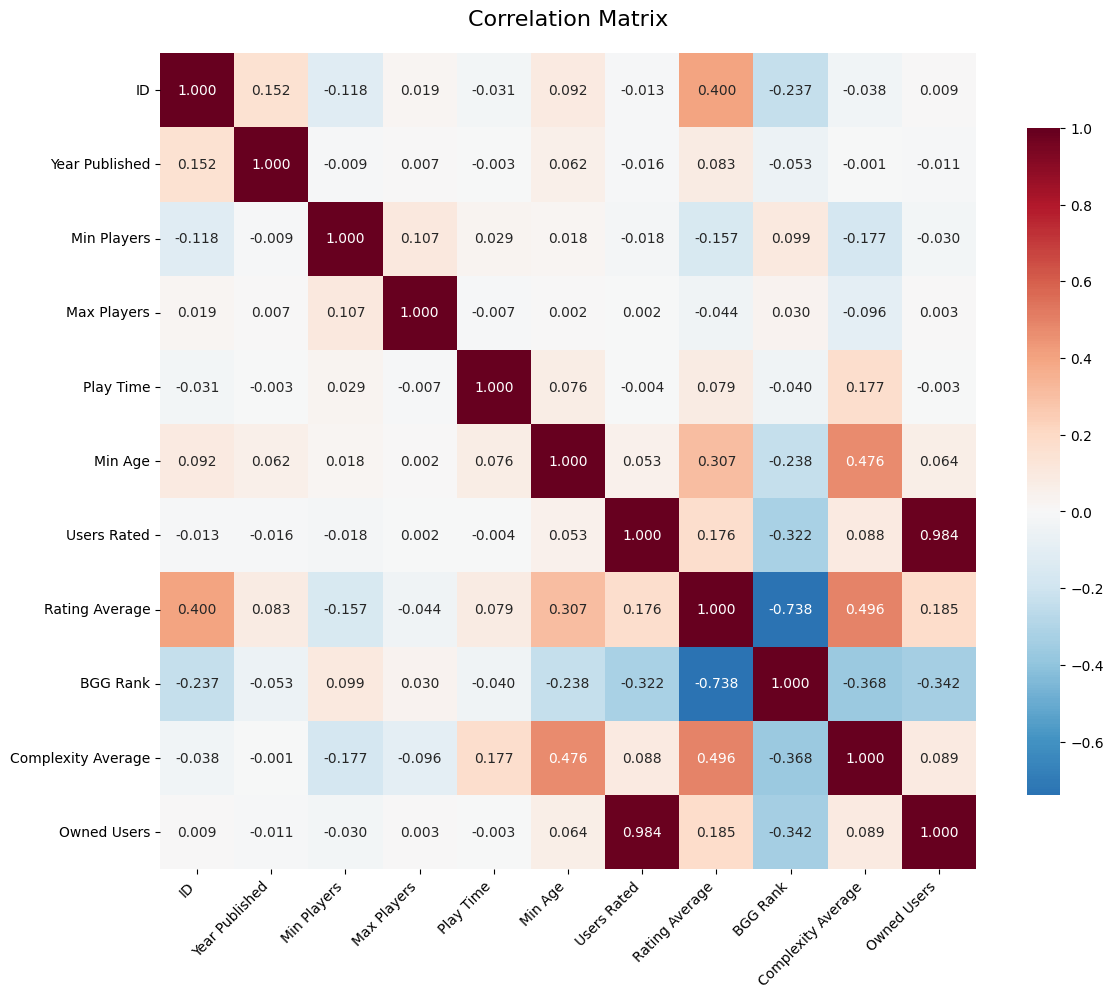

In [54]:
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix,
            annot=True,
            cmap="RdBu_r",
            center=0,
            fmt=".3f",
            square=True,
            cbar_kws={"shrink": 0.8},
            annot_kws={"size": 10})

plt.title("Correlation Matrix", fontsize=16, pad=20)
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

Качество линейной регрессии становится хуже, если ей приходится тренироваться на данных, зависящих друг от друга линейно. По этой причине одна из колонок `Users Rated`/`Owned Users` будет удалена. Колонки `Complexity Average` и `BGG Rank` неплохо коррелируют с целевой переменной, что в случае предсказания `Rating Average` должно наоборот, помочь.

In [55]:
train_df = train_df.drop(["Owned Users"], axis=1)

In [56]:
train_df.isna().sum()

,0
ID,10
Year Published,1
Min Players,0
Max Players,0
Play Time,0
Min Age,0
Users Rated,0
Rating Average,0
BGG Rank,0
Complexity Average,0


Остался один объект с неразмеченным `Year Published`.

Заменим ему год на медиану всей колонки:

In [57]:
train_df["ID"] = train_df["ID"].fillna(train_df["ID"].median())
train_df["Year Published"] = train_df["Year Published"].fillna(train_df["Year Published"].median())

### Немного фич-инжиниринга

In [58]:
train_df["player_range"] = train_df["Max Players"] - train_df["Min Players"]
train_df["player_flexibility"] = train_df["player_range"] / (train_df["Min Players"] + 0.0001)
train_df["supports_solo"] = (train_df["Min Players"] == 1).astype(int)
train_df["supports_large_groups"] = (train_df["Max Players"] >= 6).astype(int)

train_df["adult_game"] = (train_df["Min Age"] >= 16).astype(int)
train_df["family_game"] = (train_df["Min Age"] <= 12).astype(int)
train_df["complexity_per_hour"] = train_df["Complexity Average"] / ((train_df["Play Time"] + 0.0001) / 60)

train_df["complexity_squared"] = train_df["Complexity Average"] ** (1/2)
#train_df["play_time_log"] = np.log1p(train_df["Play Time"])

train_df["is_modern"] = (train_df["Year Published"] > 2010).astype(int)

train_df["popularity_density"] = train_df["Users Rated"] / (2024 - train_df["Year Published"] + 1)

## Линейная регрессия

### Препроцессинг данных

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [60]:
X = train_df.drop("Rating Average", axis=1)
y = train_df["Rating Average"]

In [61]:
print(len(X))

15257


In [62]:
NON_CATEGORIAL_FEATURES = list(X.drop(CATEGORIAL_FEATURES, axis=1).columns)

In [63]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.1,
    random_state=0
)

In [64]:
scaler = StandardScaler()
X[NON_CATEGORIAL_FEATURES] = scaler.fit_transform(X[NON_CATEGORIAL_FEATURES])
X_test[NON_CATEGORIAL_FEATURES] = scaler.transform(X_test[NON_CATEGORIAL_FEATURES])

Для работы с one-hot кодированием `sklearn` не приспособлен; будем использовать `pytorch` (тем более реализация линейной регрессии на нем очевидна - это лишь один линейный слой)

In [65]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

In [66]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [67]:
class BoardGameDataset(Dataset):
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data

    def __len__(self):
        return len(self.X_data)

    def __getitem__(self, idx):
        row = self.X_data.iloc[idx]

        numeric_features = torch.FloatTensor([row[feature] for feature in NON_CATEGORIAL_FEATURES])
        #categorial_features = [torch.FloatTensor(row[feature]).flatten() for feature in CATEGORIAL_FEATURES]

        features = torch.cat([numeric_features]) #+ categorial_features)
        target = torch.FloatTensor([self.y_data.iloc[idx]])

        return features, target


train_dataset = BoardGameDataset(X, y)  # Полная тренировка
test_dataset = BoardGameDataset(X_test, y_test)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16, shuffle=False)

### Модель и тренировка

In [68]:
class LinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(len(train_dataset[0][0]), 1)

    def forward(self, x):
        return self.linear(x)


model = LinearRegression()
model.to(device)

LinearRegression(
  (linear): Linear(in_features=19, out_features=1, bias=True)
)

In [69]:
epochs = 100
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.98)

def regularized_loss(outputs, targets, model, lambda_l1=1e-5):
    mse_loss = criterion(outputs, targets)
    l1_penalty = sum(torch.norm(param, 1) for param in model.parameters())
    return mse_loss + lambda_l1 * l1_penalty

In [70]:
from tqdm import tqdm

In [71]:
for epoch in tqdm(range(1, epochs + 1), desc="Training"):
    model.train()

    train_loss = 0.0
    for features, target in train_loader:
        features, target = features.to(device), target.to(device)

        optimizer.zero_grad()

        predicted = model(features)

        loss = regularized_loss(predicted, target, model)

        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    scheduler.step()

    if epoch % 10 == 0:
        model.eval()
        test_loss = 0.0
        #with torch.no_grad():
            #for features, target in test_loader:
            #    features, target = features.to(device), target.to(device)
            #
            #    predicted = model(features)
            #    loss = criterion(predicted, target)
            #    test_loss += loss.item()

        avg_train_loss = train_loss / len(train_loader)
        avg_test_loss = test_loss / len(test_loader)
        current_lr = scheduler.get_last_lr()[0]
        print(f"\nEpoch {epoch:4d} | LR: {current_lr:.6f} | Train MSE: {avg_train_loss:.4f} | Test MSE: {avg_test_loss:.4f}")

Training:  10%|█         | 10/100 [00:44<05:58,  3.99s/it]


Epoch   10 | LR: 0.008171 | Train MSE: 0.2939 | Test MSE: 0.0000


Training:  20%|██        | 20/100 [01:20<04:51,  3.65s/it]


Epoch   20 | LR: 0.006676 | Train MSE: 0.3119 | Test MSE: 0.0000


Training:  30%|███       | 30/100 [01:54<03:52,  3.32s/it]


Epoch   30 | LR: 0.005455 | Train MSE: 0.2970 | Test MSE: 0.0000


Training:  40%|████      | 40/100 [02:28<03:24,  3.40s/it]


Epoch   40 | LR: 0.004457 | Train MSE: 0.3126 | Test MSE: 0.0000


Training:  50%|█████     | 50/100 [03:02<02:47,  3.36s/it]


Epoch   50 | LR: 0.003642 | Train MSE: 0.2878 | Test MSE: 0.0000


Training:  60%|██████    | 60/100 [03:37<02:16,  3.42s/it]


Epoch   60 | LR: 0.002976 | Train MSE: 0.2860 | Test MSE: 0.0000


Training:  70%|███████   | 70/100 [04:11<01:43,  3.45s/it]


Epoch   70 | LR: 0.002431 | Train MSE: 0.2844 | Test MSE: 0.0000


Training:  80%|████████  | 80/100 [04:45<01:09,  3.49s/it]


Epoch   80 | LR: 0.001986 | Train MSE: 0.2834 | Test MSE: 0.0000


Training:  90%|█████████ | 90/100 [05:19<00:33,  3.32s/it]


Epoch   90 | LR: 0.001623 | Train MSE: 0.2831 | Test MSE: 0.0000


Training: 100%|██████████| 100/100 [05:53<00:00,  3.53s/it]


Epoch  100 | LR: 0.001326 | Train MSE: 0.2823 | Test MSE: 0.0000


## Подведение итогов

In [72]:
def save(model, scaler, filepath="model.pth"):
    torch.save({
        "model_state_dict": model.state_dict(),
        "scaler_mean": scaler.mean_,
        "scaler_scale": scaler.scale_,
        "input_size": model.linear.in_features
    }, filepath)

def load(filepath="model.pth"):
    checkpoint = torch.load(filepath, weights_only=False, map_location=device)

    scaler = StandardScaler()
    scaler.mean_ = checkpoint["scaler_mean"]
    scaler.scale_ = checkpoint["scaler_scale"]

    model = LinearRegression()
    model.linear = torch.nn.Linear(checkpoint["input_size"], 1)
    model.load_state_dict(checkpoint["model_state_dict"])
    model.eval()

    return model, scaler

In [73]:
save(model, scaler, "model.pth")

In [ ]:
X = train_df
NON_CATEGORIAL_FEATURES = list(X.drop(CATEGORIAL_FEATURES, axis=1).columns)
X[NON_CATEGORIAL_FEATURES] = scaler.fit_transform(X[NON_CATEGORIAL_FEATURES])

dataset = BoardGameDataset(X, pd.Series([0] * len(X)))
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=False)

model.eval()
predictions = []

with torch.no_grad():
    for features, _ in tqdm(dataloader, desc="Predicting"):
        features = features.to(device)
        outputs = model(features)
        predictions.extend(outputs.cpu().numpy().flatten())

results = pd.DataFrame({
    "Rating Average": predictions
}, index=X.index)

results.to_csv("test.csv")

Predicting: 100%|██████████| 5086/5086 [00:02<00:00, 1761.56it/s]
